In [1]:
# Import common libraries
import numpy as np
import pandas as pd
from itertools import compress

# Import MNE processing
import mne
import mne_nirs
from mne.preprocessing.nirs import optical_density, beer_lambert_law, scalp_coupling_index

# Import MNE-NIRS processing
from mne_nirs.statistics import run_glm
from mne_nirs.experimental_design import make_first_level_design_matrix
from mne_nirs.statistics import statsmodels_to_results
from mne_nirs.channels import get_short_channels, get_long_channels
from mne_nirs.channels import picks_pair_to_idx
from mne_nirs.visualisation import plot_glm_group_topo
from mne_nirs.datasets import fnirs_motor_group
from mne_nirs.visualisation import plot_glm_surface_projection, plot_nirs_source_detector
from mne_nirs.io.fold import fold_channel_specificity, fold_landmark_specificity

# Import MNE-BIDS processing
from mne_bids import BIDSPath, read_raw_bids, get_entity_vals

# Import StatsModels
import statsmodels.formula.api as smf

# Import Plotting Library
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

import h5py
from scipy import interpolate

In [2]:
def individual_analysis(bids_path, ID):

   # raw_intensity = read_raw_bids(bids_path=bids_path, verbose=False)

    raw_intensity = mne.io.read_raw_snirf(fname=bids_path, verbose=False, optode_frame="head")
    # Delete annotation labeled 15, as these just signify the start and end of experiment.

   # Rename annotations
    raw_intensity.annotations.delete(raw_intensity.annotations.description == '15')
    raw_intensity.annotations.delete(raw_intensity.annotations.description == '1')
    raw_intensity.annotations.delete(raw_intensity.annotations.description == '2')
    raw_intensity.annotations.rename({'101': 'ee', 
                                      '102': 'ee',
                                      '103': 'ee',
                                      '104': 'ee',
                                      '105': 'ee',
                                      '106': 'ee',
                                      '107': 'ee',
                                      '108': 'ee',
                                      '109': 'ee',
                                      '110': 'ee',
                                      '111': 'ee',
                                      '112': 'ee',
                                      '113': 'ee',
                                      '114': 'ee',
                                      '115': 'ee',
                                      '116': 'ii',
                                      '117': 'ii',
                                      '118': 'ii',
                                      '119': 'ii',
                                      '120': 'ii',
                                      '121': 'ii',
                                      '122': 'ii',
                                      '123': 'ii',
                                      '124': 'ii',
                                      '125': 'ii',
                                      '126': 'ii',
                                      '127': 'ii',
                                      '128': 'ii',
                                      '129': 'ii',
                                      '130': 'ii', 
                                      '131': 'ei',
                                      '132': 'ei',
                                      '133': 'ei',
                                      '134': 'ei',
                                      '135': 'ei',
                                      '136': 'ei',
                                      '137': 'ei',
                                      '138': 'ei',
                                      '139': 'ei',
                                      '140': 'ei',
                                      '141': 'ie',
                                      '142': 'ie',
                                      '143': 'ie',
                                      '144': 'ie',
                                      '145': 'ie',
                                      '146': 'ie',
                                      '147': 'ie',
                                      '148': 'ie',
                                      '149': 'ie',
                                      '150': 'ie',
                                      '11': 'ee-q', 
                                      '12': 'ii-q', 
                                      '13': 'ei-q', 
                                      '14': 'ie-q'}) 
    
    # sanitize event names
    raw_intensity.annotations.description[:] = [
        d.replace('/', '_') for d in raw_intensity.annotations.description]

    # Convert signal to haemoglobin and resample
    raw_od = optical_density(raw_intensity)
    
    # SCI threshold removal and interpolation
    sci = scalp_coupling_index(raw_od, h_freq=1.35, h_trans_bandwidth=0.1)
    raw_od.info['bads'] = list(compress(raw_od.ch_names, sci < 0.7))
    raw_od.interpolate_bads()

    
    raw_haemo = beer_lambert_law(raw_od, ppf=0.1)
    raw_haemo.resample(0.6)

    # Cut out just the short channels for creating a GLM repressor
    sht_chans = get_short_channels(raw_haemo)
    raw_haemo = get_long_channels(raw_haemo)

    # Create a design matrix #
    ###################################################################
    #   change stim_dur to the duration of the stimuli in your study   # 
    ###################################################################
    design_matrix = make_first_level_design_matrix(raw_haemo, 
                                                   drift_model = 'cosine',
                                                   high_pass = 0.015,
                                                   hrf_model = 'spm',
                                                   stim_dur=5)
    
    # Append short channels mean to design matrix
    design_matrix["ShortHbO"] = np.mean(sht_chans.copy().pick(picks="hbo").get_data(), axis=0)
    design_matrix["ShortHbR"] = np.mean(sht_chans.copy().pick(picks="hbr").get_data(), axis=0)

   #### Append WINGS aux signals to design matrix (uncomment to use) ####
    # for n in range(1, 24): # select specific aux using "for n in [1, 2, 3, 4]:" - or -  select range of aux using "for n in range(1, 24):"
    #     dat = h5py.File(bids_path, 'r')
    #     aux = np.array(dat.get(f'nirs/aux{n}/dataTimeSeries'))
    #     aux_time = np.array(dat.get(f'nirs/aux{n}/time'))
    #     aux_data_interp = interpolate.interp1d(aux_time, aux, axis=0, bounds_error=False, fill_value='extrapolate')
    #     aux_data_matched_to_fnirs = aux_data_interp(raw_haemo.times)
    #     design_matrix[np.array(dat.get(f'nirs/aux{n}/name'))[0].decode()] = aux_data_matched_to_fnirs   # raw WINGS values
    

    # Run GLM
    glm_est = run_glm(raw_haemo, design_matrix)

    ##########################################################
    #   List ROIs and the S-D pairs that go along with each   # 
    ##########################################################
    
    Left_Auditory = [[5,4], [5,5], [6,5],[6,4], [6,6], [6,7], [7,5], [7,7], [8,6], [8,7]]
    Right_Auditory = [[13,12],[13,13], [14,12], [14,13], [14,14], [14,15], [15,13], [15,15], [16,15], [16,14]]
    DLPFC = [[9,1], [9,8], [1,2], [10,9]] # [1,1], , [10,8]
    MFG = [[1,2], [1,3], [2,2], [2,3], [10,9], [10,10], [11,9], [11,10]]
    Pre_Motor = [[3,3], [3,10], [3,11], [4,3], [4,11], [12,10], [12,11]]
    # Left_PM = [[3,3], [3,11], [4,3], [4,11]]
    # Right_PM = [[3,10], [3,11], [12,10], [12,11]]
    
    # MH = [[3,3], [3,10], [3,11], [4,3], [4,11], [12,10], [12,11], [1,2], [1,3], [2,2], [2,3], [10,9], [10,10], [11,9], [11,10],[9,1], [9,8], [1,2], [10,9]]
    # Left_HG = [[5,4], [5,5], [6,4], [6,5]]
    # Left_PT = [[6,6], [6,7], [7,5], [7,7], [8,6], [8,7]]
    # Right_HG = [[13,12], [13,13], [14,12], [14,13]]
    # Right_PT = [[14,14], [14,15], [16,14], [16,15], [15,13], [15,15]]
    
    
    #############################################################
    #  Change ROIs listed below to match the ones listed above  #
    #   * Make sure to change on each side of the equal sign    #
    #   * change the conditions to the conditions you           #
    #       specified in annotations.rename above               #
    #############################################################
    
    groups = dict(
              Left_Auditory_roi = picks_pair_to_idx(raw_haemo, Left_Auditory),
              Right_Auditory_roi = picks_pair_to_idx(raw_haemo, Right_Auditory),
              DLPFC_roi = picks_pair_to_idx(raw_haemo, DLPFC),
              MFG_roi = picks_pair_to_idx(raw_haemo, MFG),
              Pre_Motor_roi = picks_pair_to_idx(raw_haemo, Pre_Motor)
              # Left_PM_roi = picks_pair_to_idx(raw_haemo, Left_PM),
              # Right_PM_roi = picks_pair_to_idx(raw_haemo, Right_PM)
              # MH_roi = picks_pair_to_idx(raw_haemo, MH),
              # Left_HG_roi = picks_pair_to_idx(raw_haemo, Left_HG),
              # Left_PT_roi = picks_pair_to_idx(raw_haemo, Left_PT),
              # Right_HG_roi = picks_pair_to_idx(raw_haemo, Right_HG),
              # Right_PT_roi = picks_pair_to_idx(raw_haemo, Right_PT)
     )
   
   # Extract channel metrics
    cha = glm_est.to_dataframe()

    # Compute region of interest results from channel data
    roi = glm_est.to_dataframe_region_of_interest(groups,
                                                  design_matrix.columns,
                                                  demographic_info=True)

    # Define left vs right tapping contrast
    contrast_matrix = np.eye(design_matrix.shape[1])
    basic_conts = dict([(column, contrast_matrix[i])
                        for i, column in enumerate(design_matrix.columns)])
    contrast_LvR = basic_conts['ee'] - basic_conts['ii']

    # Compute defined contrast
    contrast = glm_est.compute_contrast(contrast_LvR)
    con = contrast.to_dataframe()

    # Add the participant ID to the dataframes
    roi["ID"] = cha["ID"] = con["ID"] = ID

    # Convert to uM for nicer plotting below.
    cha["theta"] = [t * 1.e6 for t in cha["theta"]]
    roi["theta"] = [t * 1.e6 for t in roi["theta"]]
    con["effect"] = [t * 1.e6 for t in con["effect"]]

    return raw_haemo, roi, cha, con

## Run analysis on all participants


In [3]:
df_roi = pd.DataFrame()  # To store region of interest results
df_cha = pd.DataFrame()  # To store channel level results
df_con = pd.DataFrame()  # To store channel level contrast results

# Create path to file based on experiment info
for sub in [53, 54, 55, 56, 58, 61, 62, 64, 65, 66, 68, 69, 70, 71, 72, 74, 75, 76, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88]:  # change range values to specify the number of subject recordings to be analyzed 
    ID = 'H%03d' % sub
    bids_path = BIDSPath(subject="H%03d" % sub,
                         session="01", 
                         datatype="nirs",
                         root=r"/Users/coletrent/Library/CloudStorage/Box-Box/BRAiN Lab/current projects/elliptical-speech-project/nirs data/4ch-16ch-same-different-naive-listeners/sourcedata",
                         extension= ".snirf")
    raw_haemo, roi, cha, con= individual_analysis(bids_path, ID)
    df_roi = pd.concat([df_roi, roi], ignore_index=True)
    df_cha = pd.concat([df_cha, cha], ignore_index=True)
    df_con = pd.concat([df_con, con], ignore_index=True)

Reading 0 ... 9750  =      0.000 ...  1916.850 secs...
Setting channel interpolation method to {'fnirs': 'nearest'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 97.2 mm


/var/folders/vd/pfkq2db118d5r33plz99zgc00000gn/T/ipykernel_26174/1540102130.py:72: RuntimeWarning: Negative intensities encountered. Setting to abs(x)
  raw_od = optical_density(raw_intensity)
/var/folders/vd/pfkq2db118d5r33plz99zgc00000gn/T/ipykernel_26174/1540102130.py:77: RuntimeWarning: (X, Y) fit (0.1, -20.9) more than 20 mm from head frame origin
  raw_od.interpolate_bads()


Reading 0 ... 9634  =      0.000 ...  1894.044 secs...
Setting channel interpolation method to {'fnirs': 'nearest'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 97.2 mm


/var/folders/vd/pfkq2db118d5r33plz99zgc00000gn/T/ipykernel_26174/1540102130.py:77: RuntimeWarning: (X, Y) fit (0.1, -20.9) more than 20 mm from head frame origin
  raw_od.interpolate_bads()


Reading 0 ... 9707  =      0.000 ...  1908.396 secs...
Setting channel interpolation method to {'fnirs': 'nearest'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 97.2 mm


/var/folders/vd/pfkq2db118d5r33plz99zgc00000gn/T/ipykernel_26174/1540102130.py:77: RuntimeWarning: (X, Y) fit (0.1, -20.9) more than 20 mm from head frame origin
  raw_od.interpolate_bads()


Reading 0 ... 9457  =      0.000 ...  1859.246 secs...
Setting channel interpolation method to {'fnirs': 'nearest'}.


/var/folders/vd/pfkq2db118d5r33plz99zgc00000gn/T/ipykernel_26174/1540102130.py:77: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  raw_od.interpolate_bads()


Reading 0 ... 9647  =      0.000 ...  1896.600 secs...
Setting channel interpolation method to {'fnirs': 'nearest'}.


/var/folders/vd/pfkq2db118d5r33plz99zgc00000gn/T/ipykernel_26174/1540102130.py:77: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  raw_od.interpolate_bads()


Reading 0 ... 9642  =      0.000 ...  1895.617 secs...
Setting channel interpolation method to {'fnirs': 'nearest'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 97.2 mm


/var/folders/vd/pfkq2db118d5r33plz99zgc00000gn/T/ipykernel_26174/1540102130.py:77: RuntimeWarning: (X, Y) fit (0.1, -20.9) more than 20 mm from head frame origin
  raw_od.interpolate_bads()


Reading 0 ... 9588  =      0.000 ...  1885.001 secs...
Setting channel interpolation method to {'fnirs': 'nearest'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 97.2 mm


/var/folders/vd/pfkq2db118d5r33plz99zgc00000gn/T/ipykernel_26174/1540102130.py:77: RuntimeWarning: (X, Y) fit (0.1, -20.9) more than 20 mm from head frame origin
  raw_od.interpolate_bads()


Reading 0 ... 9429  =      0.000 ...  1853.741 secs...
Setting channel interpolation method to {'fnirs': 'nearest'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 97.2 mm


/var/folders/vd/pfkq2db118d5r33plz99zgc00000gn/T/ipykernel_26174/1540102130.py:77: RuntimeWarning: (X, Y) fit (0.1, -20.9) more than 20 mm from head frame origin
  raw_od.interpolate_bads()


Reading 0 ... 9511  =      0.000 ...  1869.863 secs...
Setting channel interpolation method to {'fnirs': 'nearest'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 97.2 mm


/var/folders/vd/pfkq2db118d5r33plz99zgc00000gn/T/ipykernel_26174/1540102130.py:77: RuntimeWarning: (X, Y) fit (0.1, -20.9) more than 20 mm from head frame origin
  raw_od.interpolate_bads()


Reading 0 ... 9408  =      0.000 ...  1849.613 secs...
Setting channel interpolation method to {'fnirs': 'nearest'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 97.2 mm


/var/folders/vd/pfkq2db118d5r33plz99zgc00000gn/T/ipykernel_26174/1540102130.py:77: RuntimeWarning: (X, Y) fit (0.1, -20.9) more than 20 mm from head frame origin
  raw_od.interpolate_bads()


Reading 0 ... 9417  =      0.000 ...  1851.382 secs...
Setting channel interpolation method to {'fnirs': 'nearest'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 97.2 mm


/var/folders/vd/pfkq2db118d5r33plz99zgc00000gn/T/ipykernel_26174/1540102130.py:77: RuntimeWarning: (X, Y) fit (0.1, -20.9) more than 20 mm from head frame origin
  raw_od.interpolate_bads()


Reading 0 ... 9632  =      0.000 ...  1893.651 secs...
Setting channel interpolation method to {'fnirs': 'nearest'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 97.2 mm


/var/folders/vd/pfkq2db118d5r33plz99zgc00000gn/T/ipykernel_26174/1540102130.py:77: RuntimeWarning: (X, Y) fit (0.1, -20.9) more than 20 mm from head frame origin
  raw_od.interpolate_bads()


Reading 0 ... 9534  =      0.000 ...  1874.384 secs...
Setting channel interpolation method to {'fnirs': 'nearest'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 97.2 mm


/var/folders/vd/pfkq2db118d5r33plz99zgc00000gn/T/ipykernel_26174/1540102130.py:77: RuntimeWarning: (X, Y) fit (0.1, -20.9) more than 20 mm from head frame origin
  raw_od.interpolate_bads()


Reading 0 ... 9944  =      0.000 ...  1954.990 secs...
Setting channel interpolation method to {'fnirs': 'nearest'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 97.2 mm


/var/folders/vd/pfkq2db118d5r33plz99zgc00000gn/T/ipykernel_26174/1540102130.py:77: RuntimeWarning: (X, Y) fit (0.1, -20.9) more than 20 mm from head frame origin
  raw_od.interpolate_bads()


Reading 0 ... 10418  =      0.000 ...  2048.179 secs...
Setting channel interpolation method to {'fnirs': 'nearest'}.


/var/folders/vd/pfkq2db118d5r33plz99zgc00000gn/T/ipykernel_26174/1540102130.py:77: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  raw_od.interpolate_bads()


Reading 0 ... 9666  =      0.000 ...  1900.336 secs...
Setting channel interpolation method to {'fnirs': 'nearest'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 97.2 mm


/var/folders/vd/pfkq2db118d5r33plz99zgc00000gn/T/ipykernel_26174/1540102130.py:77: RuntimeWarning: (X, Y) fit (0.1, -20.9) more than 20 mm from head frame origin
  raw_od.interpolate_bads()


Reading 0 ... 9539  =      0.000 ...  1875.367 secs...
Setting channel interpolation method to {'fnirs': 'nearest'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 97.2 mm


/var/folders/vd/pfkq2db118d5r33plz99zgc00000gn/T/ipykernel_26174/1540102130.py:77: RuntimeWarning: (X, Y) fit (0.1, -20.9) more than 20 mm from head frame origin
  raw_od.interpolate_bads()


Reading 0 ... 10064  =      0.000 ...  1978.582 secs...
Setting channel interpolation method to {'fnirs': 'nearest'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 97.2 mm


/var/folders/vd/pfkq2db118d5r33plz99zgc00000gn/T/ipykernel_26174/1540102130.py:77: RuntimeWarning: (X, Y) fit (0.1, -20.9) more than 20 mm from head frame origin
  raw_od.interpolate_bads()


Reading 0 ... 9406  =      0.000 ...  1849.220 secs...
Setting channel interpolation method to {'fnirs': 'nearest'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 97.2 mm


/var/folders/vd/pfkq2db118d5r33plz99zgc00000gn/T/ipykernel_26174/1540102130.py:77: RuntimeWarning: (X, Y) fit (0.1, -20.9) more than 20 mm from head frame origin
  raw_od.interpolate_bads()


Reading 0 ... 9410  =      0.000 ...  1850.006 secs...
Setting channel interpolation method to {'fnirs': 'nearest'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 97.2 mm


/var/folders/vd/pfkq2db118d5r33plz99zgc00000gn/T/ipykernel_26174/1540102130.py:77: RuntimeWarning: (X, Y) fit (0.1, -20.9) more than 20 mm from head frame origin
  raw_od.interpolate_bads()


Reading 0 ... 9751  =      0.000 ...  1917.047 secs...
Setting channel interpolation method to {'fnirs': 'nearest'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 97.2 mm


/var/folders/vd/pfkq2db118d5r33plz99zgc00000gn/T/ipykernel_26174/1540102130.py:77: RuntimeWarning: (X, Y) fit (0.1, -20.9) more than 20 mm from head frame origin
  raw_od.interpolate_bads()


Reading 0 ... 9652  =      0.000 ...  1897.583 secs...
Setting channel interpolation method to {'fnirs': 'nearest'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 97.2 mm


/var/folders/vd/pfkq2db118d5r33plz99zgc00000gn/T/ipykernel_26174/1540102130.py:77: RuntimeWarning: (X, Y) fit (0.1, -20.9) more than 20 mm from head frame origin
  raw_od.interpolate_bads()


Reading 0 ... 9679  =      0.000 ...  1902.891 secs...
Setting channel interpolation method to {'fnirs': 'nearest'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 97.2 mm


/var/folders/vd/pfkq2db118d5r33plz99zgc00000gn/T/ipykernel_26174/1540102130.py:77: RuntimeWarning: (X, Y) fit (0.1, -20.9) more than 20 mm from head frame origin
  raw_od.interpolate_bads()


Reading 0 ... 9627  =      0.000 ...  1892.668 secs...
Setting channel interpolation method to {'fnirs': 'nearest'}.


/var/folders/vd/pfkq2db118d5r33plz99zgc00000gn/T/ipykernel_26174/1540102130.py:77: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  raw_od.interpolate_bads()


Reading 0 ... 9662  =      0.000 ...  1899.549 secs...
Setting channel interpolation method to {'fnirs': 'nearest'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 97.2 mm


/var/folders/vd/pfkq2db118d5r33plz99zgc00000gn/T/ipykernel_26174/1540102130.py:77: RuntimeWarning: (X, Y) fit (0.1, -20.9) more than 20 mm from head frame origin
  raw_od.interpolate_bads()


Reading 0 ... 9732  =      0.000 ...  1913.311 secs...
Setting channel interpolation method to {'fnirs': 'nearest'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 97.2 mm


/var/folders/vd/pfkq2db118d5r33plz99zgc00000gn/T/ipykernel_26174/1540102130.py:77: RuntimeWarning: (X, Y) fit (0.1, -20.9) more than 20 mm from head frame origin
  raw_od.interpolate_bads()


Reading 0 ... 9744  =      0.000 ...  1915.670 secs...
Setting channel interpolation method to {'fnirs': 'nearest'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 97.2 mm


/var/folders/vd/pfkq2db118d5r33plz99zgc00000gn/T/ipykernel_26174/1540102130.py:77: RuntimeWarning: (X, Y) fit (0.1, -20.9) more than 20 mm from head frame origin
  raw_od.interpolate_bads()


Reading 0 ... 9578  =      0.000 ...  1883.035 secs...
Setting channel interpolation method to {'fnirs': 'nearest'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 97.2 mm


/var/folders/vd/pfkq2db118d5r33plz99zgc00000gn/T/ipykernel_26174/1540102130.py:77: RuntimeWarning: (X, Y) fit (0.1, -20.9) more than 20 mm from head frame origin
  raw_od.interpolate_bads()


## Visualize Individual results

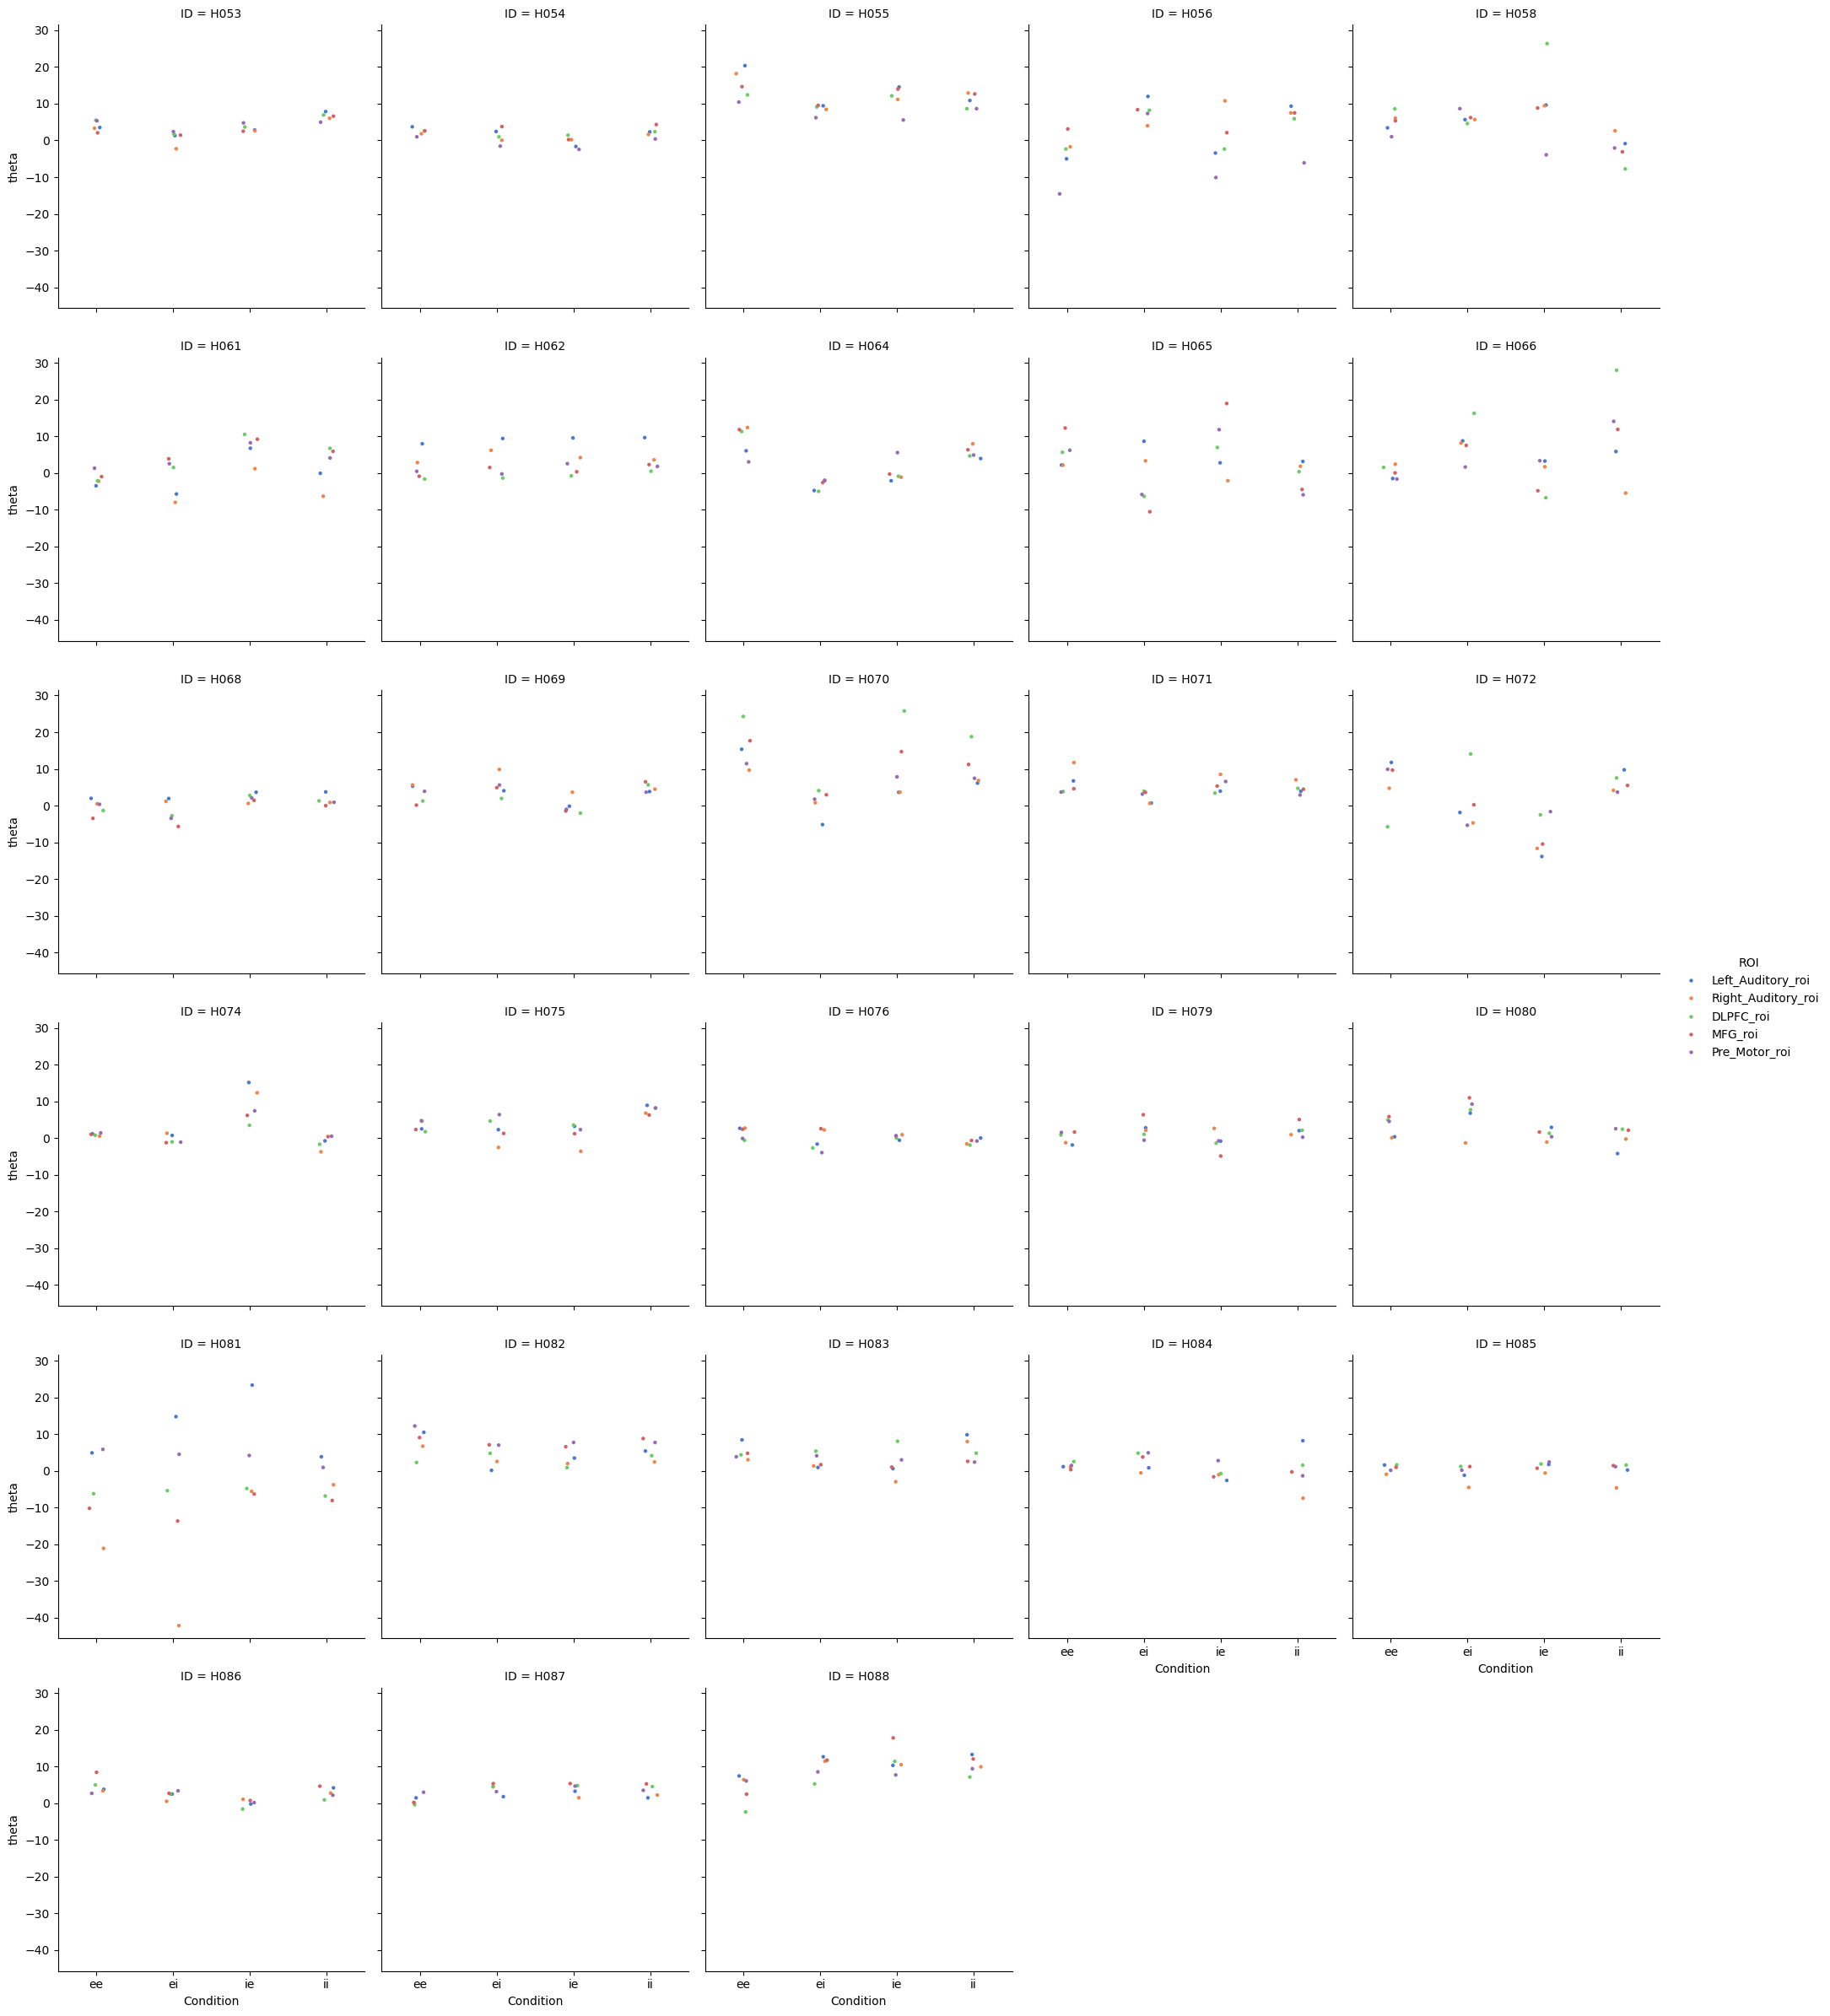

In [4]:
grp_results = df_roi.query("Condition in ['ee', 'ii', 'ei', 'ie']")
grp_results = grp_results.query("Chroma in ['hbo']")

sns.catplot(x="Condition", y="theta", col="ID", hue="ROI", data=grp_results, col_wrap=5, errorbar=None, palette="muted", height=4, s=10)

## Compute group level results


In [5]:
grp_results = df_roi.query("Condition in ['ee', 'ii', 'ie', 'ie']")

roi_model = smf.mixedlm("theta ~ -1 + ROI:Condition:Chroma",
                        grp_results, groups=grp_results["ID"]).fit(method='nm')
roi_model.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                           Mixed Linear Model Regression Results
============================================================================================
Model:                        MixedLM             Dependent Variable:             theta     
No. Observations:             840                 Method:                         REML      
No. Groups:                   28                  Scale:                          18.5809   
Min. group size:              30                  Log-Likelihood:                 -2403.3589
Max. group size:              30                  Converged:                      Yes       
Mean group size:              30.0                                                          
--------------------------------------------------------------------------------------------
                                                  Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------------------------------------------
ROI[DLPFC_roi]:Condition[ee]:Chroma[hbo]           2.796    0.862  3.244 0.001  1.107  4.486
ROI[Left_Auditory_roi]:Condition[ee]:Chroma[hbo]   4.376    0.862  5.077 0.000  2.687  6.065
ROI[MFG_roi]:Condition[ee]:Chroma[hbo]             3.858    0.862  4.476 0.000  2.169  5.548
ROI[Pre_Motor_roi]:Condition[ee]:Chroma[hbo]       3.193    0.862  3.704 0.000  1.503  4.882
ROI[Right_Auditory_roi]:Condition[ee]:Chroma[hbo]  2.961    0.862  3.435 0.001  1.271  4.650
ROI[DLPFC_roi]:Condition[ie]:Chroma[hbo]           3.736    0.862  4.334 0.000  2.047  5.425
ROI[Left_Auditory_roi]:Condition[ie]:Chroma[hbo]   3.546    0.862  4.114 0.000  1.857  5.235
ROI[MFG_roi]:Condition[ie]:Chroma[hbo]             3.202    0.862  3.714 0.000  1.512  4.891
ROI[Pre_Motor_roi]:Condition[ie]:Chroma[hbo]       2.924    0.862  3.392 0.001  1.235  4.613
ROI[Right_Auditory_roi]:Condition[ie]:Chroma[hbo]  2.108    0.862  2.445 0.014  0.418  3.797
ROI[DLPFC_roi]:Condition[ii]:Chroma[hbo]           4.334    0.862  5.028 0.000  2.645  6.024
ROI[Left_Auditory_roi]:Condition[ii]:Chroma[hbo]   4.712    0.862  5.467 0.000  3.023  6.402
ROI[MFG_roi]:Condition[ii]:Chroma[hbo]             4.189    0.862  4.860 0.000  2.500  5.879
ROI[Pre_Motor_roi]:Condition[ii]:Chroma[hbo]       2.860    0.862  3.318 0.001  1.170  4.549
ROI[Right_Auditory_roi]:Condition[ii]:Chroma[hbo]  2.404    0.862  2.788 0.005  0.714  4.093
ROI[DLPFC_roi]:Condition[ee]:Chroma[hbr]          -0.841    0.862 -0.976 0.329 -2.531  0.848
ROI[Left_Auditory_roi]:Condition[ee]:Chroma[hbr]  -0.098    0.862 -0.114 0.910 -1.787  1.592
ROI[MFG_roi]:Condition[ee]:Chroma[hbr]            -0.428    0.862 -0.497 0.619 -2.118  1.261
ROI[Pre_Motor_roi]:Condition[ee]:Chroma[hbr]      -0.581    0.862 -0.674 0.500 -2.271  1.108
ROI[Right_Auditory_roi]:Condition[ee]:Chroma[hbr] -0.683    0.862 -0.793 0.428 -2.373  1.006
ROI[DLPFC_roi]:Condition[ie]:Chroma[hbr]          -0.221    0.862 -0.256 0.798 -1.911  1.468
ROI[Left_Auditory_roi]:Condition[ie]:Chroma[hbr]  -0.235    0.862 -0.273 0.785 -1.925  1.454
ROI[MFG_roi]:Condition[ie]:Chroma[hbr]            -0.521    0.862 -0.604 0.546 -2.210  1.169
ROI[Pre_Motor_roi]:Condition[ie]:Chroma[hbr]      -1.248    0.862 -1.448 0.148 -2.937  0.442
ROI[Right_Auditory_roi]:Condition[ie]:Chroma[hbr] -0.881    0.862 -1.022 0.307 -2.570  0.809
ROI[DLPFC_roi]:Condition[ii]:Chroma[hbr]          -0.456    0.862 -0.529 0.596 -2.146  1.233
ROI[Left_Auditory_roi]:Condition[ii]:Chroma[hbr]  -0.277    0.862 -0.322 0.748 -1.967  1.412
ROI[MFG_roi]:Condition[ii]:Chroma[hbr]            -0.902    0.862 -1.046 0.295 -2.591  0.787
ROI[Pre_Motor_roi]:Condition[ii]:Chroma[hbr]      -1.151    0.862 -1.335 0.182 -2.840  0.538
ROI[Right_Auditory_roi]:Condition[ii]:Chroma[hbr] -1.083    0.862 -1.256 0.209 -2.772  0.606
Group Var                                          2.223    0.183                           
=========================================================================

In [6]:
## Print dataframe with ROIs

In [7]:
df_roi.to_csv("4ch_5-sec-boxcar_LR-PM_09-13-24.csv")

## Visualize group results


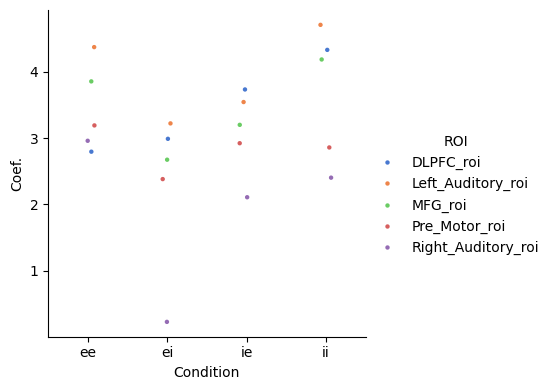

In [6]:
# Regenerate the results from the original group model above
grp_results = df_roi.query("Condition in ['ee','ii','ei','ie']")
roi_model = smf.mixedlm("theta ~ -1 + ROI:Condition:Chroma",
                        grp_results, groups=grp_results["ID"]).fit(method='nm')

df = statsmodels_to_results(roi_model)

sns.catplot(x="Condition", y="Coef.", hue="ROI", data=df.query("Chroma == 'hbo'"), errorbar=None, palette="muted", height=4, s=10)

## Group topographic visualization - sentence and silence



/var/folders/vd/pfkq2db118d5r33plz99zgc00000gn/T/ipykernel_8348/2848676697.py:16: RuntimeWarning: MNE data structure does not match regression results
  plot_glm_group_topo(raw_haemo.copy().pick(picks="hbo"),
/var/folders/vd/pfkq2db118d5r33plz99zgc00000gn/T/ipykernel_8348/2848676697.py:21: RuntimeWarning: MNE data structure does not match regression results
  plot_glm_group_topo(raw_haemo.copy().pick(picks="hbo"),


<Axes: title={'center': 'ii'}>

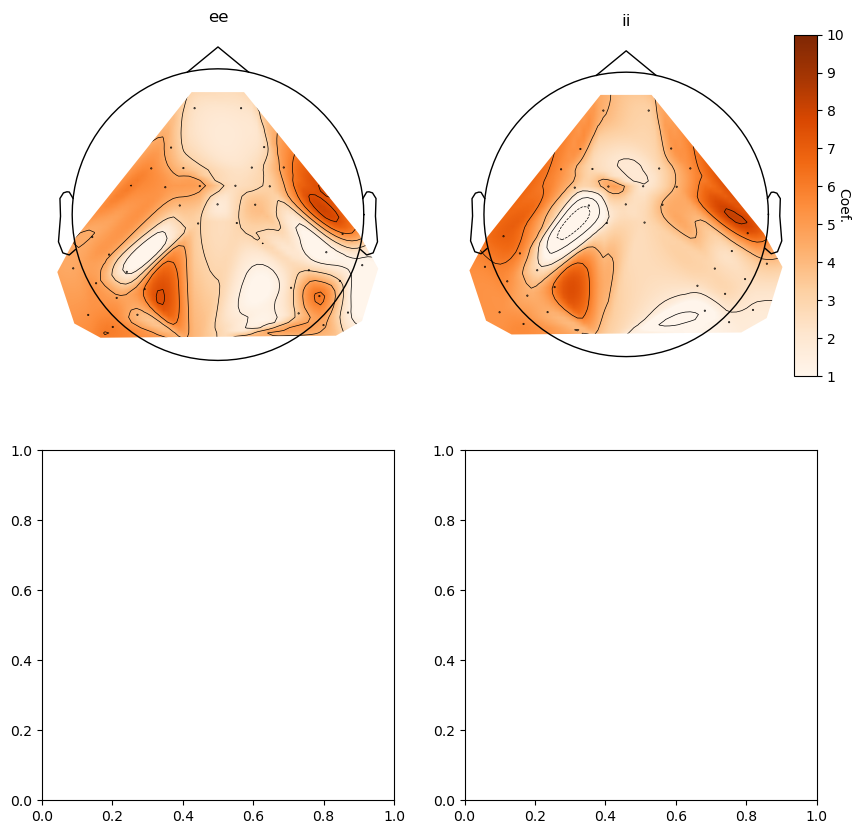

In [7]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 10),
                         gridspec_kw=dict(width_ratios=[1, 1]))


##### HbO
# Cut down the dataframe just to the conditions we are interested in
ch_summary = df_cha.query("Condition in ['ee', 'ii', 'ei', 'ie']")
ch_summary = ch_summary.query("Chroma in ['hbo']")

# Run group level model and convert to dataframe
ch_model = smf.mixedlm("theta ~ -1 + ch_name:Chroma:Condition",
                       ch_summary, groups=ch_summary["ID"]).fit(method='nm')
ch_model_df = statsmodels_to_results(ch_model)

# Plot the two conditions
plot_glm_group_topo(raw_haemo.copy().pick(picks="hbo"),
                    ch_model_df.query("Condition in ['ee']"),
                    colorbar=False, axes=axes[0, 0],
                    vlim=(1, 10), cmap=mpl.cm.Oranges)

plot_glm_group_topo(raw_haemo.copy().pick(picks="hbo"),
                    ch_model_df.query("Condition in ['ii']"),
                    colorbar=True, axes=axes[0, 1],
                    vlim=(1, 10), cmap=mpl.cm.Oranges)

# plot_glm_group_topo(raw_haemo.copy().pick(picks="hbo"),
#                     ch_model_df.query("Condition in ['Left Button']"),
#                     colorbar=False, axes=axes[0, 0],
#                     vlim=(1, 5), cmap=mpl.cm.Oranges)

# plot_glm_group_topo(raw_haemo.copy().pick(picks="hbo"),
#                     ch_model_df.query("Condition in ['Right Button']"),
#                     colorbar=True, axes=axes[0, 1],
#                     vlim=(1, 5), cmap=mpl.cm.Oranges)

#### HbR
# Cut down the dataframe just to the conditions we are interested in
# ch_summary = df_cha.query("Condition in ['8 sec active sentence', 'silence + button']")
# ch_summary = ch_summary.query("Chroma in ['hbr']")

# # Run group level model and convert to dataframe
# ch_model = smf.mixedlm("theta ~ -1 + ch_name:Chroma:Condition",
#                        ch_summary, groups=ch_summary["ID"]).fit(method='nm')
# ch_model_df = statsmodels_to_results(ch_model)

# # Plot the two conditions
# plot_glm_group_topo(raw_haemo.copy().pick(picks="hbr"),
#                     ch_model_df.query("Condition in ['8 sec active sentence']"),
#                     colorbar=False, axes=axes[1, 0],
#                     vlim=(-10, 0), cmap=mpl.cm.Blues_r)
# plot_glm_group_topo(raw_haemo.copy().pick(picks="hbr"),
#                     ch_model_df.query("Condition in ['silence + button']"),
#                     colorbar=True, axes=axes[1, 1],
#                     vlim=(-10, 0), cmap=mpl.cm.Blues_r)

## Group topographic visualization - button presses



/var/folders/vd/pfkq2db118d5r33plz99zgc00000gn/T/ipykernel_8348/1972007541.py:26: RuntimeWarning: MNE data structure does not match regression results
  plot_glm_group_topo(raw_haemo.copy().pick(picks="hbo"),
/var/folders/vd/pfkq2db118d5r33plz99zgc00000gn/T/ipykernel_8348/1972007541.py:31: RuntimeWarning: MNE data structure does not match regression results
  plot_glm_group_topo(raw_haemo.copy().pick(picks="hbo"),


<Axes: title={'center': 'ii'}>

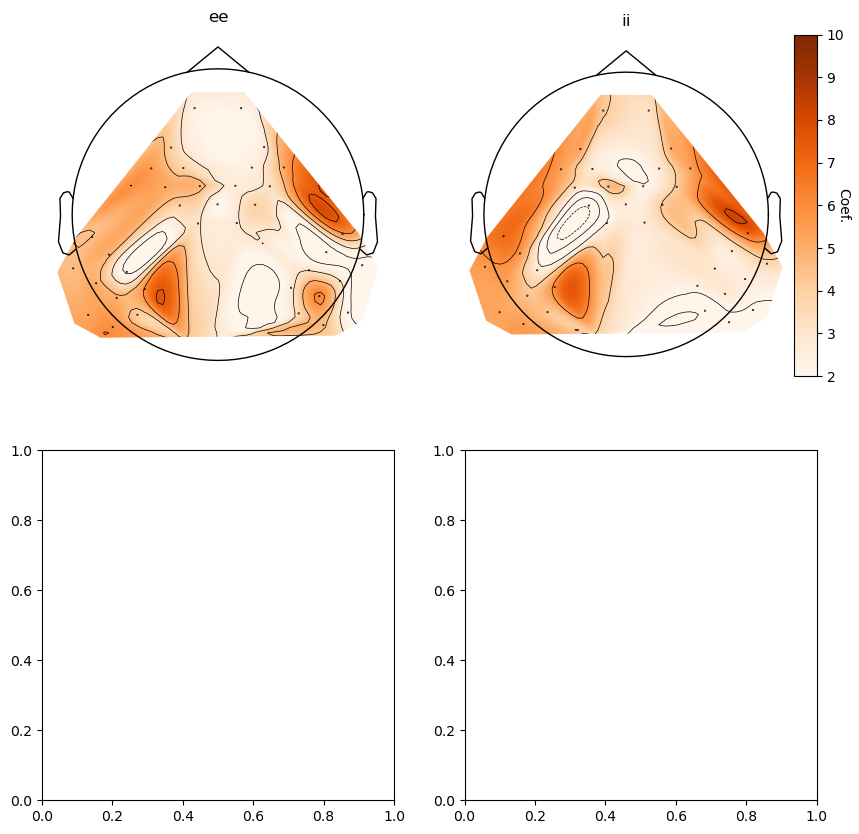

In [8]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 10),
                         gridspec_kw=dict(width_ratios=[1, 1]))


##### HbO
# Cut down the dataframe just to the conditions we are interested in
ch_summary = df_cha.query("Condition in ['ee', 'ii', 'ei', 'ie']")
ch_summary = ch_summary.query("Chroma in ['hbo']")

# Run group level model and convert to dataframe
ch_model = smf.mixedlm("theta ~ -1 + ch_name:Chroma:Condition",
                       ch_summary, groups=ch_summary["ID"]).fit(method='nm')
ch_model_df = statsmodels_to_results(ch_model)

# Plot the two conditions
# plot_glm_group_topo(raw_haemo.copy().pick(picks="hbo"),
#                     ch_model_df.query("Condition in ['8 sec active sentence']"),
#                     colorbar=False, axes=axes[0, 0],
#                     vlim=(1, 5), cmap=mpl.cm.Oranges)

# plot_glm_group_topo(raw_haemo.copy().pick(picks="hbo"),
#                     ch_model_df.query("Condition in ['silence + button']"),
#                     colorbar=True, axes=axes[0, 1],
#                     vlim=(1, 5), cmap=mpl.cm.Oranges)

plot_glm_group_topo(raw_haemo.copy().pick(picks="hbo"),
                    ch_model_df.query("Condition in ['ee']"),
                    colorbar=False, axes=axes[0, 0],
                    vlim=(2, 10), cmap=mpl.cm.Oranges)

plot_glm_group_topo(raw_haemo.copy().pick(picks="hbo"),
                    ch_model_df.query("Condition in ['ii']"),
                    colorbar=True, axes=axes[0, 1],
                    vlim=(2, 10), cmap=mpl.cm.Oranges)

## Contrasts

Finally we can examine the difference between the left and right hand
tapping conditions by viewing the contrast results
in a topographic representation.



<Axes: title={'center': 'Contrast'}>

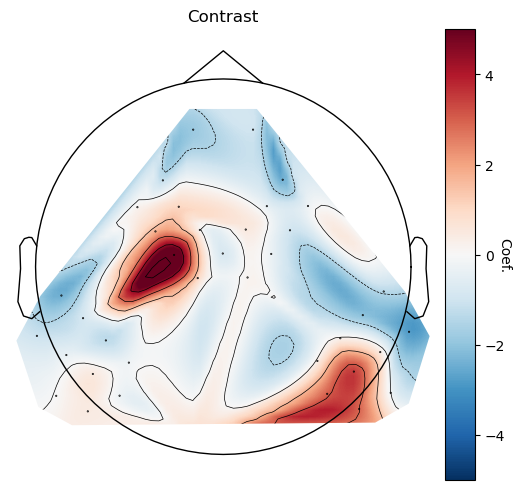

In [9]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))
con_summary = df_con.query("Chroma in ['hbo']")

# Run group level model and convert to dataframe
con_model = smf.mixedlm("effect ~ -1 + ch_name:Chroma", #:Chroma
                        con_summary, groups=con_summary["ID"]).fit(method='nm')
con_model_df = statsmodels_to_results(con_model,
                                      order=raw_haemo.copy().pick(
                                          picks="hbo").ch_names)

plot_glm_group_topo(raw_haemo.copy().pick(picks="hbo"),
                    con_model_df, colorbar=True, axes=axes, vlim=(-5, 5))

Or we can view only the left hemisphere for the contrast.
And set all channels that dont have a significant response to zero.




## Cortical Surface Projections


In [11]:
# Generate brain figure from data
subjects_dir = mne.datasets.sample.data_path() / 'subjects'
clim = dict(kind='value', pos_lims=(0, 8, 11))
brain = plot_glm_surface_projection(raw_haemo.copy().pick("hbo"),
                                    con_model_df, clim=clim, view='dorsal',
                                    colorbar=True, size=(800, 700), subjects_dir=subjects_dir)
brain.add_text(0.05, 0.95, "Contrast", 'title', font_size=16, color='k')

# Run model code as above
clim = dict(kind='value', pos_lims=(0, 11.5, 17))
for idx, cond in enumerate(['ee', 'ii']):

    # Run same model as explained in the sections above
    ch_summary = df_cha.query("Condition in [@cond]")
    ch_summary = ch_summary.query("Chroma in ['hbo']")
    ch_model = smf.mixedlm("theta ~ -1 + ch_name", ch_summary,
                           groups=ch_summary["ID"]).fit(method='nm')
    model_df = statsmodels_to_results(ch_model, order=raw_haemo.copy().pick("hbo").ch_names)

    # Generate brain figure from data
    brain = plot_glm_surface_projection(raw_haemo.copy().pick("hbo"),
                                        model_df, clim=clim, view='dorsal',
                                        colorbar=True, size=(800, 700), subjects_dir=subjects_dir)
    brain.add_text(0.05, 0.95, cond, 'title', font_size=16, color='k')

In [39]:
brain = mne.viz.Brain(
    "fsaverage", subjects_dir=subjects_dir, background="w", cortex=".75", size = (800, 700)
)

brain.add_sensors(
    raw.info, trans="fsaverage", fnirs=["channels", "pairs", "sources", "detectors"]
)
brain.show_view(azimuth=180, elevation=90, distance=450)

Channel types::	fnirs_cw_amplitude: 94


/var/folders/vd/pfkq2db118d5r33plz99zgc00000gn/T/ipykernel_15560/2042099921.py:5: RuntimeWarning: Got coordinate frame "unknown" for ['S1_D1 760', 'S1_D1 760', 'S1_D1 760', 'S1_D2 760', 'S1_D2 760', 'S1_D2 760', 'S1_D3 760', 'S1_D3 760', 'S1_D3 760', 'S1_D16 760', 'S1_D16 760', 'S1_D16 760', 'S2_D2 760', 'S2_D2 760', 'S2_D2 760', 'S2_D3 760', 'S2_D3 760', 'S2_D3 760', 'S3_D3 760', 'S3_D3 760', 'S3_D3 760', 'S3_D10 760', 'S3_D10 760', 'S3_D10 760', 'S3_D11 760', 'S3_D11 760', 'S3_D11 760', 'S4_D3 760', 'S4_D3 760', 'S4_D3 760', 'S4_D11 760', 'S4_D11 760', 'S4_D11 760', 'S4_D17 760', 'S4_D17 760', 'S4_D17 760', 'S5_D4 760', 'S5_D4 760', 'S5_D4 760', 'S5_D5 760', 'S5_D5 760', 'S5_D5 760', 'S6_D4 760', 'S6_D4 760', 'S6_D4 760', 'S6_D5 760', 'S6_D5 760', 'S6_D5 760', 'S6_D6 760', 'S6_D6 760', 'S6_D6 760', 'S6_D7 760', 'S6_D7 760', 'S6_D7 760', 'S6_D18 760', 'S6_D18 760', 'S6_D18 760', 'S7_D5 760', 'S7_D5 760', 'S7_D5 760', 'S7_D7 760', 'S7_D7 760', 'S7_D7 760', 'S8_D6 760', 'S8_D6 760', 'S8

## Table of channel level results

Sometimes a reviewer wants a long table of results per channel.
This can be generated from the statistics dataframe.



In [33]:
ch_summary = df_cha.query("Condition in ['ee', 'ii']")
ch_summary = ch_summary.query("Chroma in ['hbo']")

# Run group level model and convert to dataframe
ch_model = smf.mixedlm("theta ~ -1 + ch_name:Chroma:Condition",
                       ch_summary, groups=ch_summary["ID"]).fit(method='nm')

# Here we can use the order argument to ensure the channel name order
ch_model_df = statsmodels_to_results(ch_model,
                                     order=raw_haemo.copy().pick(
                                         picks="hbo").ch_names)
# And make the table prettier
ch_model_df.reset_index(drop=True, inplace=True)
ch_model_df = ch_model_df.set_index(['ch_name', 'Condition'])
ch_model_df

Coef.  Std.Err.         z     P>|z|    [0.025  \
ch_name     Condition                                                     
S1_D2 hbo   ee         4.007574  2.312442  1.733049  0.083087 -0.524728   
            ii         4.327409  2.312442  1.871359  0.061295 -0.204894   
S1_D3 hbo   ee         4.989384  2.312442  2.157626  0.030957  0.457081   
            ii         0.989039  2.312442  0.427703  0.668867 -3.543263   
S2_D2 hbo   ee         3.932703  2.312442  1.700671  0.089005 -0.599599   
...                         ...       ...       ...       ...       ...   
S15_D15 hbo ii         1.116352  2.312442  0.482759  0.629267  -3.41595   
S16_D14 hbo ee         3.934967  2.312442  1.701650  0.088821 -0.597336   
            ii         4.500266  2.312442  1.946110  0.051642 -0.032037   
S16_D15 hbo ee         2.218864  2.312442  0.959533  0.337290 -2.313439   
            ii         1.937047  2.312442  0.837663  0.402220 -2.595256   

                         0.975] Chroma  Significant  
ch_name     Condition                                
S1_D2 hbo   ee         8.539877    hbo        False  
            ii         8.859711    hbo        False  
S1_D3 hbo   ee         9.521686    hbo         True  
            ii         5.521342    hbo        False  
S2_D2 hbo   ee         8.465006    hbo        False  
...                         ...    ...          ...  
S15_D15 hbo ii         5.648655    hbo        False  
S16_D14 hbo ee         8.467269    hbo        False  
            ii         9.032568    hbo        False  
S16_D15 hbo ee         6.751166    hbo        False  
            ii         6.469349    hbo        False  

[74 rows x 8 columns]


## Relating Responses to Brain Landmarks

.. sidebar:: fOLD Toolbox

   You should use the fOLD toolbox to pick your optode locations
   when designing your experiment.
   The tool is very intuitive and easy to use.
   Be sure to cite the authors if you use their tool or data:

   Morais, Guilherme Augusto Zimeo, Joana Bisol Balardin, and João Ricardo Sato. "fNIRS optodes’ location decider (fOLD): a toolbox for probe arrangement guided by brain regions-of-interest." Scientific reports 8.1 (2018): 1-11.

It can be useful to understand what brain structures
the measured response may have resulted from. Here we illustrate
how to report the brain structures/landmarks that the source
detector pair with the largest response was sensitive to.

First we determine the channel with the largest response.

Next, we query the fOLD dataset to determine the
brain landmarks that this channel is most sensitive to.
MNE-NIRS does not distribute the fOLD toolbox or the data
that they provide. See the Notes section of
:func:`mne_nirs.io.fold_channel_specificity` for more information.



In [34]:
largest_response_channel = ch_model_df.loc[ch_model_df['Coef.'].idxmax()]
largest_response_channel

Coef.           8.884132
Std.Err.        2.312442
z               3.841883
P>|z|           0.000122
[0.025          4.351829
0.975]         13.416434
Chroma               hbo
Significant         True
Name: (S7_D5 hbo, ii), dtype: object

Next we use information from the fOLD toolbox to report the
channel specificity to different brain regions.
For licensing reasons, these files are not distributed with MNE-NIRS.
To set up your system to use the fOLD functions, see the Notes section of
:func:`mne_nirs.io.fold_channel_specificity`.



In [35]:
raw_channel = raw_haemo.copy().pick(largest_response_channel.name[0])
fold_channel_specificity(raw_channel)[0]

ValueError: MNE_NIRS_FOLD_PATH not set, either set it using mne.set_config or pass fold_files as str or list

We observe that the channel with the largest response to tapping
had the greatest specificity to the Precentral Gyrus, which is
the site of the primary motor cortex. This is consistent
with the expectation for a finger tapping task.



## Conclusion

This example has demonstrated how to perform a group level analysis
using a GLM approach.
We observed the responses were evoked primarily contralateral to the
hand of tapping and most likely originate from the primary motor cortex.

